# Figure 2: Spline generalized linear model (GLM) captures dLGN tuning properties.

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import re
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, randomized_svd
from statannotations.Annotator import Annotator
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [102]:
# Define the preprocessing function for the .csv file
def preprocess_array_string(s):
    # Remove any newline characters
    s = s.replace('\n', ' ')
    # Ensure commas between numbers using a more robust regular expression
    s = re.sub(r'(?<=\d)\s+(?=-?\d)', ', ', s)
    return s

def str_to_array(s):
    try:
        return np.array(ast.literal_eval(s))
    except (SyntaxError, ValueError) as e:
        print(f"Error parsing string: {s}")
        raise e

In [3]:
def get_color_dict(palette_name='colorblind', n=None, color_names=None,
                   add_default_colors=True):
    """
    Returns color map dictionary from seaborn color palettes with hexadecimal triplet values.

    Parameters
    ----------
    palette_name : str
        Name of palette. Possible values are:
        'colorblind', 'deep', 'muted', 'bright', 'pastel', 'dark'
        For more options see seaborn.color_palette() docs.
    n : int
        Number of colors.
        If not None and arg color_names is given, arg n must be equal to len(color_names).
    color_names : list
        List of color names as strings e.g. for the color palette 'colorblind': ['blue',
        'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue']
        Must have the same length as colors in the color palette.
        If None, color names are set to ['c0', 'c1', 'c2', ...].
    add_default_colors : bool
        Add default colors that are need but that are not part of the color palette such as
        e.g. 'black'.
        If set to False, the color dict will only contain colors of the chosen palette.

    Returns
    -------
    color_dict: dict
         Color name as key and color triplet as value.
    """
    # Import done here to avoid problems for other user who don't have seaborn installed
    import seaborn as sns

    # Get list of sns colors as hexadecimal triplet
    sns_colors_l = sns.color_palette(palette_name).as_hex()
    if n is not None:
        sns_colors_l = sns_colors_l[:n]
    # Define color names if none are given
    if color_names is None:
        color_names = ["c%d" % i for i in range(0, len(sns_colors_l))]
    # Create color dict
    color_dict = dict.fromkeys(color_names)
    for color_name, color in zip(color_names, sns_colors_l):
        color_dict[color_name] = color
    # Add additional colors to palette
    if add_default_colors is True:
        color_dict['black'] = '#000000'

    return color_dict

def get_strf_comps(strf):
    """
    Get spatial and temporal components of spatio-temporal receptive field (stRF), typically
    given as vector with dimensions (time, height, width) obtained from model weights.
    Current method uses singular value decomposition (SVD) components as sRF and tRF.

    Parameters
    ----------
    strf : array
        3D vector with dimensions (time, height, width).

    Returns
    --------
    sRF : array
        Spatial RF component given as 2D (height, width) array.
    tRF : array
        Temporal RF component given as 1D (time) array.

    TODO:
      - consider giving input key arg instead of strf vector
      - consider implementing different method apart from SVD
      - consider option to flip SVD-component for OFF-RF here, not outside in plot_rf_filter()
      - There is a Flip_sign param in the normalized_svd method
    """

    # Normalized RF
    strf_vec = strf.flatten()
    k_norm = strf_vec / np.linalg.norm(strf_vec)

    # SVD
    dims_tRF = strf.shape[0]
    dims_sRF = strf.shape[1:]
    U, S, Vt = randomized_svd(k_norm.reshape(dims_tRF, np.prod(dims_sRF)), 3)
    sRF = Vt[0].reshape(*dims_sRF)
    tRF = U[:, 0]  # temporal RF

    return sRF, tRF

def measure_fwhm(trf):
    # Normalize TRF
    trf_normalized = trf / np.max(trf)

    # Find maximum response
    max_response = np.max(trf_normalized)

    # Determine half-maximum threshold
    half_max_threshold = max_response / 2.0

    # Find rising and falling edges
    rising_edge = np.where(trf_normalized >= half_max_threshold)[0][0]
    falling_edge = np.where(trf_normalized >= half_max_threshold)[0][-1]

    # Measure FWHM
    fwhm = falling_edge - rising_edge

    return fwhm


def get_formatted_pvals(pvals, stars=False, show_ns_val=True):
    for p in pvals:
        formatted_pval_plot = []
        if 1.00e-02 < p <= 5.00e-02:
            if stars:
                formatted_pval_plot.append('*')
            else:
                formatted_pval_plot.append('p<0.05')
        elif 1.00e-03 < p <= 1.00e-02:
            if stars:
                formatted_pval_plot.append('**')
            else:
                formatted_pval_plot.append('p<0.01')
        elif 1.00e-04 < p <= 1.00e-03:
            if stars:
                formatted_pval_plot.append('***')
            else:
                formatted_pval_plot.append('p<0.001')
        elif p <= 1.00e-04:
            if stars:
                formatted_pval_plot.append('****')
            else:
                formatted_pval_plot.append('p<0.0001')
        else:
            formatted_pval_plot.append('p={:.3f}'.format(p)) 
    return formatted_pval_plot

In [4]:
color_dict = get_color_dict(color_names=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue'])

# Load data

In [112]:
filename = './data/population_data_movie_June24.csv'
data_population = pd.read_csv(filename, converters={'filt_opto': preprocess_array_string, 'filt_run': preprocess_array_string, 'filt_eye': preprocess_array_string})

# Apply the function to convert strings to arrays in the 'filt_opto' column
data_population['filt_opto'] = data_population['filt_opto'].apply(str_to_array)
data_population['filt_run'] = data_population['filt_run'].apply(str_to_array)
data_population['filt_eye'] = data_population['filt_eye'].apply(str_to_array)

In [32]:
filename = '/gpfs01/berens/user/lschmors/Code/dLGN_project/hollymov_code_20230906/figures/code/data/strfs_spline_old.h5'
data_strf = pd.read_hdf(filename, "df")

# Define example neurons

In [29]:
keys = [{'m': 'Ntsr1Cre_2019_0008', 's': 5, 'e': 8, 'u': 19},
        {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 6, 'u': 35},
        {'m': 'Ntsr1Cre_2019_0008', 's': 3, 'e': 7, 'u': 25},
       ]

In [30]:
from rfest.splines import cr, build_spline_matrix

key = keys[0]
filename = './data/{:s}_s{:02d}_e{:02d}_u{:02d}.h5'.format(key['m'], key['s'], key['e'], key['u'])
data = pd.read_hdf(filename, "df")

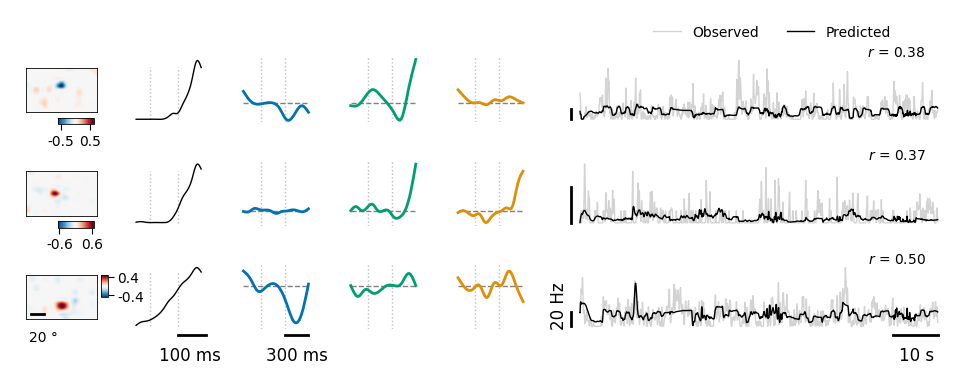

In [75]:
cmap = 'RdBu_r'
key = keys[0]

srf_panels = ['a', 'h', 'o']
trf_panels = ['b', 'i', 'p']
opto_panels = ['c', 'j', 'q']
run_panels = ['d', 'k', 'r']
eye_panels = ['e', 'l', 's']
pred_panels = ['f', 'm', 't']

# sRF
#vmax_sRF = .5
sRF_xlim = [0,20] # degrees of visual angle

#tRF
data_fs = 60
ts = 1/data_fs
ylim_trf = [-.1, .6]

# predictions
pred_start_sec = -3
pred_stop_sec = 80
pred_y_bar = 20
pred_ylim = [-40,120]
pred_x_bar = 10

perm_xlim = [-.1,.6]
perm_ylim = [-.5, 3.5]

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    abcdeffff
    hijklmmmm
    opqrstttt
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(6, 1.8),
        dpi=200,
        #constrained_layout=True,
        #sharex=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    for i, key in enumerate(keys):
    
        filename = './data/{:s}_s{:02d}_e{:02d}_u{:02d}.h5'.format(key['m'], key['s'], key['e'], key['u'])
        data = pd.read_hdf(filename, "df")
        strf = data.at[0,'strf']
        sRF = data.at[0,'srf']
        vmax_sRF = np.max([abs(np.min(sRF)), np.max(sRF)])
        dims_sRF = sRF.shape
        #width_deg = data.at[0, 'stim_width_deg']
        tRF = data.at[0,'trf']
        tRF_spl = data_strf[np.array((data_strf['m']==key['m']) & (data_strf['s']==key['s']) & (data_strf['e']==key['e']) & (data_strf['u']==key['u']))]['trf_spl'].values[0]
        #tRF_spl = data.at[0,'trf_spl']
        opto_kernel = data.at[0,'filt_opto']
        run_kernel = data.at[0,'filt_run']
        eye_kernel = data.at[0,'filt_eye']
        kernel_ylim = [np.hstack([opto_kernel, run_kernel, eye_kernel]).min()-.1, np.hstack([opto_kernel, run_kernel, eye_kernel]).max()+.1]
        # Predictions
        pred_tv = np.linspace(0, data.at[0,'y_test'].shape[0] / data_fs, data.at[0,'y_test'].shape[0])
        pred_trange = [np.where(pred_tv>pred_start_sec)[0][0], np.where(pred_tv>pred_stop_sec)[0][0]]
        obs = data.at[0,'y_test'][pred_trange[0]:pred_trange[1]]
        pred = data.at[0,'yhat_test'][pred_trange[0]:pred_trange[1]]
        tv = pred_tv[pred_trange[0]:pred_trange[1]]
        
        # sRF
        ax = ax_dict[srf_panels[i]]    
        im = ax.imshow(sRF, cmap='RdBu_r', interpolation='spline16', vmin=-vmax_sRF, vmax=vmax_sRF, origin='lower')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        if srf_panels[i] in ['a', 'h']:
            axins = inset_axes(
                            ax,
                            width="50%",  # width: 5% of parent_bbox width
                            height="15%",  # height: 50%
                            loc="center",
                            bbox_to_anchor=(0.2, -0.7, 1, 1),
                            bbox_transform=ax.transAxes,
                            borderpad=0,
            )
            cbar = fig.colorbar(im, cax=axins, ticks=[-np.round(vmax_sRF-.1,1), np.round(vmax_sRF-.1,1)], orientation='horizontal')
            cbar.ax.tick_params(labelsize=5)
            cbar.set_ticklabels([-np.round(vmax_sRF-.1,1), np.round(vmax_sRF-.1,1)])
        if srf_panels[i]=='o':
            axins = inset_axes(
                            ax,
                            width="10%",  # width: 5% of parent_bbox width
                            height="50%",  # height: 50%
                            loc="center",
                            bbox_to_anchor=(0.6, 0.25, 1, 1),
                            bbox_transform=ax.transAxes,
                            borderpad=0,
            )
            cbar = fig.colorbar(im, cax=axins, ticks=[-np.round(vmax_sRF-.1,1), np.round(vmax_sRF-.1,1)], orientation='vertical')
            cbar.ax.tick_params(labelsize=5)
            cbar.set_ticklabels([-np.round(vmax_sRF-.1,1), np.round(vmax_sRF-.1,1)])

        # tRF
        ax = ax_dict[trf_panels[i]]
        x_axis_trf = np.arange(-tRF.shape[0]*ts, 0, ts)*1000 # ms
        x_axis_trf_spl = np.linspace(x_axis_trf[0], x_axis_trf[-1], tRF_spl.shape[0])
        ax.plot(x_axis_trf_spl, tRF_spl, 'k')
        for xtick in [-200, -100]:
            ax.vlines(x=xtick, ymin=0, ymax=tRF.max(), color='gray', linestyle=':', alpha=.5)
        #ax.set_ylim(ylim_trf)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        # opto kernel
        ax = ax_dict[opto_panels[i]]
        x_axis_opto = (np.arange(-(opto_kernel.shape[0]*ts)-ts, 0-ts, ts)*1000).astype('int') # ms
        ax.plot(x_axis_opto, opto_kernel, color_dict['blue'], lw=1)
        ax.hlines(y=0, xmin=x_axis_opto[0], xmax=x_axis_opto[-1], color='gray', linestyle='--', lw=.5)
        for xtick in [-633, -333]:
            ax.vlines(x=xtick, ymin=kernel_ylim[0], ymax=kernel_ylim[1], color='gray', linestyle=':', alpha=.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_ylim(kernel_ylim)
        
        # run kernel
        ax = ax_dict[run_panels[i]]
        x_axis_run = (np.arange(-(run_kernel.shape[0]*ts)-ts, 0-ts, ts)*1000).astype('int') # ms
        ax.plot(x_axis_run, run_kernel, color_dict['green'], lw=1)
        ax.hlines(y=0, xmin=x_axis_run[0], xmax=x_axis_run[-1], color='gray', linestyle='--', lw=.5)
        for xtick in [-633, -333]:
            ax.vlines(x=xtick, ymin=kernel_ylim[0], ymax=kernel_ylim[1], color='gray', linestyle=':', alpha=.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_ylim(kernel_ylim)

        # eye kernel
        ax = ax_dict[eye_panels[i]]
        x_axis_eye = (np.arange(-(eye_kernel.shape[0]*ts)-ts, 0-ts, ts)*1000).astype('int') # ms
        ax.hlines(y=0, xmin=x_axis_eye[0], xmax=x_axis_eye[-1], color='gray', linestyle='--', lw=.5)
        ax.plot(x_axis_eye, eye_kernel, color_dict['orange'], lw=1)
        for xtick in [-633, -333]:
            ax.vlines(x=xtick, ymin=kernel_ylim[0], ymax=kernel_ylim[1], color='gray', linestyle=':', alpha=.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_ylim(kernel_ylim)
        
        # predictions
        ax = ax_dict[pred_panels[i]]
        ax.plot(tv, obs, color='lightgray', label='Observed',lw=.5)
        ax.plot(tv, pred, color='black', label='Predicted', lw=.5)
        #ax.set_ylim(pred_ylim)
        # correlation coefficient
        ax.set_title('$r$ = {:.2f}'.format(data.at[0,'r_test']), fontsize=5, x=.85, y=.9)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
    # x axis
    # sRF
    #deg_per_pix_w = width_deg / dims_sRF[1]  
    num_px = 4#round(sRF_xlim[1]/deg_per_pix_w)
    ax_dict['o'].plot([1, num_px+1], [1, 1], 'k', lw=1)
    ax_dict['o'].set_xlabel(f'{sRF_xlim[1]} °', fontsize=5, x=0.25)
    # tRF
    ax_dict['p'].spines['bottom'].set_visible(True)
    ax_dict['p'].spines['bottom'].set_bounds([-100,0])
    ax_dict['p'].spines['bottom'].set_linewidth(1)
    ax_dict['p'].spines['bottom'].set_position(('outward', 2))
    #fig.text(s='100 ms', fontsize=5, x=.24, y=0.0)
    ax_dict['p'].set_xlabel('100 ms', y=0, x=.8)
    # kernel
    ax_dict['q'].spines['bottom'].set_visible(True)    
    ax_dict['q'].spines['bottom'].set_bounds((x_axis_opto[-1]-300, x_axis_opto[-1]))
    ax_dict['q'].spines['bottom'].set_linewidth(1)
    ax_dict['q'].spines['bottom'].set_position(('outward', 2))
    #fig.text(s='300 ms', fontsize=5, x=.35, y=0.0)
    ax_dict['q'].set_xlabel('300 ms', y=0, x=.8)
    # predictions
    ax_dict['t'].spines['bottom'].set_visible(True)
    ax_dict['t'].spines['bottom'].set_bounds([pred_stop_sec, pred_stop_sec-pred_x_bar])
    ax_dict['t'].spines['bottom'].set_linewidth(1)
    ax_dict['t'].spines['bottom'].set_position(('outward', 2))
    ax_dict['t'].set_xlabel(f'{pred_x_bar} s', y=0, x=.9)
    ax_dict['f'].legend(ncol=2, frameon=False, bbox_to_anchor=[.2,1.1])
    #fig.text(s=f'{pred_x_bar} ms', fontsize=5, x=.45, y=0.0) 
    
    # y axis
    # predictions
    for label in ['f', 'm', 't']:
        ax_dict[label].spines['left'].set_visible(True)
        ax_dict[label].spines['left'].set_bounds([0, pred_y_bar])
        ax_dict[label].spines['left'].set_linewidth(1)
        ax_dict[label].spines['left'].set_position(('data', -2))
    
    ax_dict['t'].set_ylabel(f'{pred_y_bar} Hz', loc='bottom', labelpad=1)
    #fig.text(s=f'{pred_y_bar} Hz', fontsize=5, x=0.61, y=.2, rotation=90)

    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    
# Save plot
filename_plot = './plots/Fig2/example_neurons'
fig.patch.set_facecolor('white')
fig.savefig(filename_plot+'.svg', facecolor=fig.get_facecolor(), transparent=False, bbox_inches='tight')

Permutation test:

Neuron 1:
	stimulus p-value = 5.72E-02
	opto p-value = 5.75E-07
	run p-value = 4.85E-01
	eye p-value = 5.21E-01
Neuron 2:
	stimulus p-value = 2.31E-03
	opto p-value = 1.00E+00
	run p-value = 1.06E-01
	eye p-value = 5.72E-03
Neuron 3:
	stimulus p-value = 2.31E-03
	opto p-value = 5.75E-07
	run p-value = 6.80E-01
	eye p-value = 8.76E-01


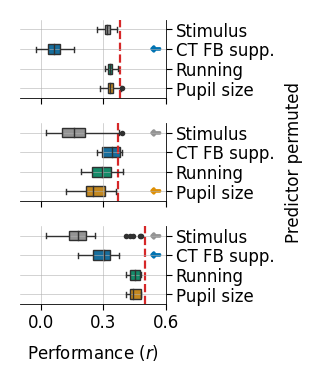

In [76]:
alpha = .05

perm_panels = ['a', 'b', 'c']
with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    b
    c
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1.5, 1.8),
        dpi=200,
        #constrained_layout=True,
        #sharex=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    for i, key in enumerate(keys):
    
        filename = './data/{:s}_s{:02d}_e{:02d}_u{:02d}.h5'.format(key['m'], key['s'], key['e'], key['u'])
        data = pd.read_hdf(filename, "df")
        
        # Get permutation scores
        scores_all = []
        label = []
        perm_kernel_idxs = []
        for k, kernel_type in enumerate(['stim', 'opto','run', 'eye']):
            scores = data.at[0,'perm_score_{:s}'.format(kernel_type)]
            scores_all.append(scores)
            for s in range(scores.shape[0]):
                label.append(kernel_type)
            perm_kernel_idxs.append(np.ones((scores.shape[0]))*k)
        scores_all = np.hstack(scores_all)
        perm_kernel_idxs = np.hstack(perm_kernel_idxs)
        perm_df = pd.DataFrame(dict(kernel=label,score=scores_all, idx=perm_kernel_idxs))
        # p-values 
        pvals = data_population[(data_population['m']==key['m']) & 
                                                   (data_population['s']==key['s']) & 
                                                   (data_population['e']==key['e']) & 
                                                   (data_population['u']==key['u'])][['perm_pvalue_stim', 'perm_pvalue_opto', 'perm_pvalue_run', 'perm_pvalue_eye']].values[0]
        idx_kernel_signif = np.where(pvals<alpha)[0]
        print(f'Neuron {i+1}:')
        print('\tstimulus p-value = {:.2E}'.format(pvals[0]))
        print('\topto p-value = {:.2E}'.format(pvals[1]))
        print('\trun p-value = {:.2E}'.format(pvals[2]))
        print('\teye p-value = {:.2E}'.format(pvals[3]))
        
        # Plotting
        ax = ax_dict[perm_panels[i]]
        palette = [color_dict['gray'], color_dict['blue'], color_dict['green'], color_dict['orange']]
        sns.boxplot(data=perm_df, 
                    x='score', 
                    y='idx', 
                    orient='h',
                ax=ax,
                palette=palette,
                fliersize=2,
                flierprops={"marker": "."},
                    width=0.5,
               )
        for idx_kernel in idx_kernel_signif:
            ax.scatter(0.55, idx_kernel, marker='$\leftarrow$', color=palette[idx_kernel], s=10)

        ax.axvline(x=data.at[0,'r_test'], color='tab:red', linestyle='--', lw=.8, zorder=1)
        ax.set_xticks(np.linspace(0,perm_xlim[-1], 3))
        ax.yaxis.tick_right()
        ax.set_yticks(np.linspace(0,3,4))
        ax.set_yticklabels(['Stimulus', 'CT FB supp.','Running', 'Pupil size'])
        ax.set_xlim(perm_xlim)
        ax.set_ylim(perm_ylim)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(True)
        if i<2:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        else:
            ax.yaxis.set_label_position("right")
            ax.set_xlabel('Performance ($r$)')
        if i == 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel('Predictor permuted')
        else:
            ax.set_ylabel('')
        ax.invert_yaxis()
        ax.grid(lw=.2)
        
# Save plot
filename_plot = './plots/Fig2/example_neurons_perm_scores'
#fig.patch.set_facecolor('white')
fig.savefig(filename_plot+'.svg', facecolor=fig.get_facecolor(), transparent=False, bbox_inches='tight')

# Population analysis

In [113]:
# tRF
tRFs = np.vstack(data_strf['trf_spl'].values)
tRF_tv = np.vstack(data_strf['trf_spl_tv'].values)[0]
p_values_tRF = data_population['perm_pvalue_stim'].values
# Account for polarity to not show in temporal kernel
tRFs_flip = []
tRFs_flip_AUC = []
for i in range(tRFs.shape[0]):
    tRF = tRFs[i,:]
    # Account for rotation invariance of SVD
    if sum(tRF[50:])<0:
        tRF = tRF*(-1) 
    tRFs_flip.append(tRF)
    tRFs_flip_AUC.append(np.sum(tRF))
# Sort tRFs by AUC  
tRFs_flip = np.vstack(tRFs_flip)
idxs = np.array(tRFs_flip_AUC)
idxs_sorted_idxs = np.flip(np.array(idxs).argsort())
tRFs_sorted = tRFs_flip[idxs_sorted_idxs[::-1]]
p_values_tRF_sorted = np.expand_dims(p_values_tRF[idxs_sorted_idxs], axis=1)

# Opto
kernels_opto = np.vstack(data_population['filt_opto'].values)
p_values_opto = data_population['perm_pvalue_opto'].values
# Sort by area under the curve of the kernel
idxs = sum(kernels_opto.T)
idxs_sorted_idxs = np.array(idxs).argsort()
idxs_sorted_idxs = np.flip(idxs_sorted_idxs)
kernels_opto_sorted = kernels_opto[idxs_sorted_idxs[::-1]]
p_values_opto_sorted = np.expand_dims(p_values_opto[np.flip(idxs_sorted_idxs)], axis=1)

# Run
kernels_run = np.vstack(data_population['filt_run'].values)
p_values_run = data_population['perm_pvalue_run'].values
# Sort by area under the curve of the kernel
idxs = sum(kernels_run.T)
idxs_sorted_idxs = np.array(idxs).argsort()
kernels_run_sorted = kernels_run[idxs_sorted_idxs[::-1]]
p_values_run_sorted = np.expand_dims(p_values_run[np.flip(idxs_sorted_idxs)], axis=1)

# Eye
kernels_eye = np.vstack(data_population['filt_eye'].values)
p_values_eye = data_population['perm_pvalue_eye'].values
# Sort by area under the curve of the kernel
idxs = sum(kernels_eye.T)
idxs_sorted_idxs = np.array(idxs).argsort()
kernels_eye_sorted = kernels_eye[idxs_sorted_idxs[::-1]]
p_values_eye_sorted = np.expand_dims(p_values_eye[np.flip(idxs_sorted_idxs)], axis=1)

data_fs = 60
ts = 1/data_fs
kernels_tv = (np.arange(-(kernels_opto.shape[1]*ts), 0-ts/2, ts)*1000).astype('int') # ms

Significant tRF neurons: (85/122) 69%
Significant opto neurons: (12/122) 9%
Significant run neurons: (13/122) 10%
Significant eye neurons: (23/122) 18%


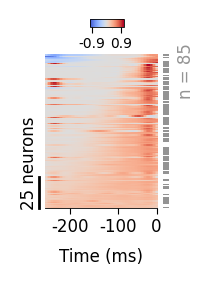

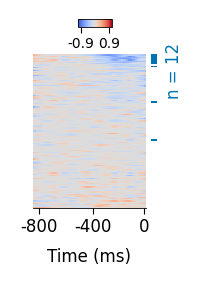

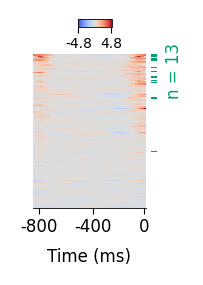

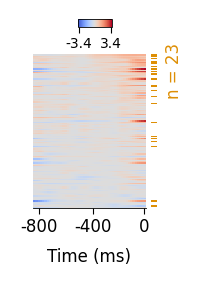

In [135]:
cmap='coolwarm'
signif_level = 0.05

# Loop over kernels
kernel_names = ['tRF', 'opto', 'run', 'eye']
kernels_sorted = [tRFs_sorted, kernels_opto_sorted, kernels_run_sorted, kernels_eye_sorted]
kernels_pval_sorted = [p_values_tRF_sorted, p_values_opto_sorted, p_values_run_sorted, p_values_eye_sorted]
kernel_tv = [tRF_tv, kernels_tv, kernels_tv, kernels_tv]
kernel_tv_label = [np.array([0, -100, -200]), np.array([0, -400, -800]), np.array([0, -400, -800]), np.array([0, -400, -800])]
colors = [color_dict['gray'], color_dict['blue'], color_dict['green'], color_dict['orange']]
    
for i in range(len(kernel_names)):
    with plt.style.context("matplotlib_config.txt"):
        mosaic = """
        ab
        """
        fig, ax_dict = plt.subplot_mosaic(
            mosaic,
            figsize=(.8,1.02),
            gridspec_kw={"width_ratios":[1, 0.05]},
            #constrained_layout=True,
            #sharex=True,
        )

        txt_kwargs = dict(
            color="black", fontsize="larger"
        )
        axs=[ax_dict['a'], ax_dict['b']]

        # Plotting
        cmap_pvalues = LinearSegmentedColormap.from_list(colors[i], ['white', 'white'], N=10)
        cmap_pvalues.set_under(colors[i])
        #kernel_vminmax = np.max([np.abs(np.max(kernels_sorted[i])), np.abs(np.min(kernels_sorted[i]))])-.2
        kernel_vminmax = np.max([np.max(kernels_sorted[i]), abs(np.min(kernels_sorted[i]))])
        xticklabels = kernel_tv_label[i]
        xticks = []
        for xticklabel in xticklabels:
            closest_val_tv = abs(abs(kernel_tv[i])-np.abs(xticklabel)).argmin()
            xticks.append(closest_val_tv)
        # heatmap
        ax = axs[0]
        im = ax.imshow(kernels_sorted[i], cmap=cmap, vmin=-kernel_vminmax, vmax=kernel_vminmax, aspect='auto', interpolation='None')
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.set_yticks([])
        ax.set_xlabel('Time (ms)')
        # colorbar
        axins = inset_axes(
                        ax,
                        width="30%",  # width: 5% of parent_bbox width
                        height="5%",  # height: 50%
                        loc="center",
                        bbox_to_anchor=(0.05, .7, 1, 1),
                        bbox_transform=ax.transAxes,
                        borderpad=0,
        )
        cbar = fig.colorbar(im, cax=axins, ticks=[-np.round(kernel_vminmax,1)+.1, np.round(kernel_vminmax,1)-.1], orientation='horizontal')
        cbar.ax.tick_params(labelsize=5)
        cbar.set_ticklabels([-np.round(kernel_vminmax,1), np.round(kernel_vminmax,1)])

        sns.despine(left=True)

        # p-values
        ax = axs[1]
        num_signif_neur = np.where(kernels_pval_sorted[i]<0.05)[0].shape[0]
        print('Significant {:s} neurons: ({:d}/122) {:d}%'.format(kernel_names[i], num_signif_neur, int(num_signif_neur/122*100)))
        ax.imshow(kernels_pval_sorted[i], vmin=signif_level, cmap=cmap_pvalues, aspect='auto', interpolation='None')
        ax.axes.set_axis_off()
        #ax.set_title('n = {:d}'.format(num_signif_neur), color=colors[i], y=1.01, loc='left')
        fig.text(s='n = {:d}'.format(num_signif_neur), color=colors[i], x=.95, y=.68, rotation=90)
        
        # y axis
        if i==0:
            ax_dict['a'].spines['left'].set_visible(True)
            ax_dict['a'].spines['left'].set_bounds([kernels_sorted[i].shape[0]-1, kernels_sorted[i].shape[0]-25])
            ax_dict['a'].spines['left'].set_linewidth(1)
            ax_dict['a'].spines['left'].set_position(('outward', 2))
            fig.text(s=f'25 neurons', x=-.03, y=.14, rotation=90)
        else:
            ax_dict['a'].spines['left'].set_visible(False)

        fig.subplots_adjust(wspace=0.1)

    # Save plot
    filename_plot = './plots/Fig2/population_results_{:s}'.format(kernel_names[i])
    fig.patch.set_facecolor('none')
    fig.savefig(filename_plot+'.svg', transparent=True, bbox_inches='tight')

# Stats on 'Pupil size' kernel vs. 'Running' kernel

* time from half max to peak

In [115]:
alpha = 0.05

data_fs = 60
ts = 1/data_fs
kernels_tv = (np.arange(-(kernels_opto.shape[1]*ts), 0-ts/2, ts)*1000).astype('int') # ms

kernels_run = np.vstack(data_population['filt_run'].values)
p_values_run = data_population['perm_pvalue_run'].values
idx_run_signif = np.where(p_values_run<alpha)[0]
kernels_run_signif = kernels_run[idx_run_signif,:]

kernels_eye = np.vstack(data_population['filt_eye'].values)
p_values_eye = data_population['perm_pvalue_eye'].values
idx_eye_signif = np.where(p_values_eye<alpha)[0]
kernels_eye_signif = kernels_eye[idx_eye_signif,:]

In [116]:
def get_t_half_max_to_peak(kernel, kernel_tv):
    peak_val = np.max(kernel_)
    half_peak_val = peak_val/2
    idx_peak = np.where(kernel_==peak_val)[0][0]
    idx_half_peak = np.argmin(abs(kernel_[:idx_peak]-half_peak_val))
    peak_time = kernel_tv_[idx_peak]
    half_peak_time = kernel_tv_[idx_half_peak]
    time_half_peak_to_peak = np.diff([half_peak_time, peak_time])[0] #ms
    return time_half_peak_to_peak

In [117]:
run_kernel_t_to_peak = []
for i in idx_run_signif:
    kernel_ = kernels_run[i, 10:]
    kernel_tv_ = kernels_tv[10:]
    
    run_kernel_t_to_peak.append(get_t_half_max_to_peak(kernel_, kernel_tv_))

In [118]:
eye_kernel_t_to_peak = []
for i in idx_eye_signif:
    kernel_ = kernels_eye[i, 10:]
    kernel_tv_ = kernels_tv[10:]
    
    eye_kernel_t_to_peak.append(get_t_half_max_to_peak(kernel_, kernel_tv_))

In [120]:
_,pval = scipy.stats.mannwhitneyu(x=eye_kernel_t_to_peak, y=run_kernel_t_to_peak)
formatted_pval = get_formatted_pvals(pvals=[pval])

In [121]:
print('mean eye: ', np.round(np.mean(eye_kernel_t_to_peak), 2))

print('mean run: ', np.round(np.mean(run_kernel_t_to_peak), 2))

print('p-val: ', pval)

mean eye:  155.26
mean run:  96.0
p-val:  0.0055001081518737055


In [122]:
df_half_peak = pd.DataFrame(dict(kernel=['run']*idx_run_signif.shape[0]+['eye']*idx_eye_signif.shape[0],
                     t_half_max_to_peak = run_kernel_t_to_peak+eye_kernel_t_to_peak))


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

run vs. eye: p<0.01


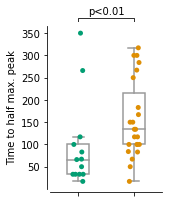

In [134]:
fig, ax = plt.subplots(1,1,figsize=(2,3))


sns.stripplot(ax=ax,
              data=df_half_peak, 
              orient="v", 
              x='kernel',
              y='t_half_max_to_peak',
              palette=[color_dict['green'], color_dict['orange']],
              s=5, 
              jitter=0.1, 
             )
sns.boxplot(ax=ax,
              data=df_half_peak, 
              orient="v", 
              x='kernel',
              y='t_half_max_to_peak',
              palette=['white', 'white'], 
            width=.4,
            flierprops={"marker": ""},
             )
#sns.boxplot(data=df_half_peak,
#           x='kernel',
#           y='t_half_max_to_peak',
#           palette=[color_dict['green'], color_dict['orange']],
#           width=.5, 
#           ax=ax)
ax.set_xticklabels([' ', ' '])
ax.set_ylabel('Time to half max. peak')
ax.set_xlabel('')

# Annotations
annotator = Annotator(ax=ax, 
                      pairs=[('run', 'eye')], 
                      data=df_half_peak, 
                      y='t_half_max_to_peak',
                      x='kernel',
                      order=None, 
                      orient='v',
                      short_test_name=False)
annotator.set_custom_annotations(formatted_pval)
annotator.configure(loc='outside', fontsize=10, line_width=1)
annotator.annotate()   

sns.despine(offset=3)

# Save plot
filename_plot = './plots/Fig2/kerne_run_eye_t_half_max'
fig.patch.set_facecolor('none')
fig.savefig(filename_plot+'.svg', transparent=True, bbox_inches='tight')